In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from src.fractions_utils import FracContext, FractionalEncoderUtils, FractionalDecryptorUtils
from src.encarray import EncArray
from src.linear_regression import SecureLinearRegression
from src.main import generate_dataset

from time import time
from matplotlib import pyplot
from sklearn.datasets import make_regression
import numpy as np

%load_ext autoreload
%autoreload 2

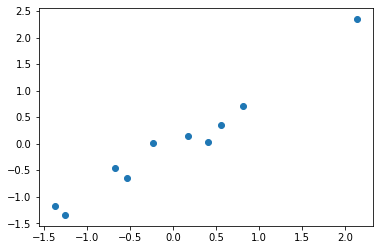

In [2]:
X, y = generate_dataset(10, 1, 10)
X_without_intercept = X[:,0]
X = X.tolist()
y = y.tolist()
pyplot.scatter(X_without_intercept, y)
pyplot.show()

In [90]:
X

[-1.407, 0.537, 0.808, 1.081, 0.537, -1.257, -0.281, -0.734, 1.616, -0.901]

In [3]:
context = FracContext()
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)

/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19


## Timings of basic HE operations

In [131]:
# testing numbers
a = 13
b = 42

In [145]:
enc_a = encode_utils.encrypt_num(a)
enc_b = encode_utils.encrypt_num(b)

In [ ]:
## time for encoding

In [151]:
%%timeit
enc_a = encode_utils.encrypt_num(a)
enc_b = encode_utils.encrypt_num(b)


38.2 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [147]:
%%timeit
encode_utils.add(enc_a, enc_b)

54.6 ms ± 953 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [148]:
%%timeit
encode_utils.subtract(enc_a, enc_b)

78.3 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [150]:
%%timeit
encode_utils.multiply(enc_a, enc_b)

442 ms ± 7.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [152]:
%%timeit
enc_a = EncArray(a, encode_utils)
enc_b = EncArray(b, encode_utils)

42.3 ms ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [119]:
%%timeit
enc_a + enc_b

80.2 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [120]:
%%timeit
enc_a - enc_b

87.9 ms ± 691 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [121]:
%%timeit
enc_a * enc_b

242 ms ± 4.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Timings of Linear Regression model 

In [5]:
X_enc = EncArray(X, encode_utils)
y_enc = EncArray(y, encode_utils)

In [122]:
%%timeit
model = SecureLinearRegression()
model.fit_unencrypted(X, y, n_iter=1)

170 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [123]:
%%timeit
model = SecureLinearRegression()
model.fit(X_enc, y_enc, n_iter=1, decode_utils=decode_utils, verbose=False)

Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
23.5 s ± 505 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Timings of different initialization parameters

In [8]:
X, y = generate_dataset(10, 1, 15)
X_enc, y_enc = EncArray(X.tolist(), enc_utils=encode_utils), EncArray(y.tolist(), enc_utils=encode_utils)
print(f'X shape: {X.shape}, y shape: {y.shape}')

X shape: (10, 2), y shape: (10, 1)


In [19]:
%%timeit
context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)

print(f'================= Secure LR ==================')
init_weights = None
model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=True)

weights = model.weigths.decrypt_array(decode_utils)
print(f'Estimated parameters: {weights}')
print(f'Prediction: {model.predict(X_enc).decrypt_array(decode_utils)}. Real values: {y.T}')

# Reencprypting weights
init_weights = EncArray(weights, enc_utils=encode_utils)

/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
================= Secure LR ==================
Iteration: 0. Gradient: [2.8185484705176996e+18, -2.1904753235157558e+18]. Noise budget: [0, 0]. Size of weights: 4
Estimated parameters: [-2.840309242290651e+18, -1.9479552325552476e+18]
Prediction: [[7.31121308118771e+18, -3.1229471133062385e+18], [8.908254104717412e+17, -7.710677872769674e+18], [-9.659730661351928e+17, -3.697333629585569e+17], [7.960778589986693e+16, -1.262980942232074e+18], [3.856813895355288e+18, -8.742566829814706e+18], [5.7577563986738496e+17, 2.709260271551061e+17], [4.186984739599433e+18, -3.299146713319843e+17]]. Real values: [[-0.13575432 -0.73107937 -0.36508054  0.20249348  0.60314044  1.91874422
  -1.49246391]]
/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
============

In [23]:
X, y = generate_dataset(10, 1, 15)
X_enc, y_enc = EncArray(X.tolist(), enc_utils=encode_utils), EncArray(y.tolist(), enc_utils=encode_utils)
print(f'X shape: {X.shape}, y shape: {y.shape}')

X shape: (10, 2), y shape: (10, 1)


In [24]:
%%timeit
context = FracContext(poly_modulus="1x^2048 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)

print(f'================= Secure LR ==================')
init_weights = None
model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=True)

weights = model.weigths.decrypt_array(decode_utils)
print(f'Estimated parameters: {weights}')
print(f'Prediction: {model.predict(X_enc).decrypt_array(decode_utils)}. Real values: {y.T}')

# Reencprypting weights
init_weights = EncArray(weights, enc_utils=encode_utils)

/ Encryption parameters:
| poly_modulus: 1x^2048 + 1
| coeff_modulus_size: 1200 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
================= Secure LR ==================


ValueError: encrypted is not valid for encryption parameters

In [ ]:
context = FracContext(poly_modulus="1x^8192 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)

print(f'================= Secure LR ==================')
init_weights = None
model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=True)

weights = model.weigths.decrypt_array(decode_utils)
print(f'Estimated parameters: {weights}')
print(f'Prediction: {model.predict(X_enc).decrypt_array(decode_utils)}. Real values: {y.T}')

# Reencprypting weights
init_weights = EncArray(weights, enc_utils=encode_utils)

In [ ]:
## Different number of prime numbers

In [ ]:
%%timeit
context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)

print(f'================= Secure LR ==================')
init_weights = None
model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=True)

weights = model.weigths.decrypt_array(decode_utils)
print(f'Estimated parameters: {weights}')
print(f'Prediction: {model.predict(X_enc).decrypt_array(decode_utils)}. Real values: {y.T}')

# Reencprypting weights
init_weights = EncArray(weights, enc_utils=encode_utils)

In [21]:
%%timeit
context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=80, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecryptorUtils(context)

print(f'================= Secure LR ==================')
init_weights = None
model.fit(X_enc, y_enc, decode_utils, init_weights, n_iter=1, verbose=True)

weights = model.weigths.decrypt_array(decode_utils)
print(f'Estimated parameters: {weights}')
print(f'Prediction: {model.predict(X_enc).decrypt_array(decode_utils)}. Real values: {y.T}')

# Reencprypting weights
init_weights = EncArray(weights, enc_utils=encode_utils)

/ Encryption parameters:
| poly_modulus: 1x^1024 + 1
| coeff_modulus_size: 3600 bits
| plain_modulus: 4294967296
| noise_standard_deviation: 3.19
================= Secure LR ==================


ValueError: encrypted is not valid for encryption parameters

In [ ]:
%%timeit
context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=140, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecoderUtils(context)
model = SecureLinearRegression()
model.fit(X_enc, y_enc, n_iter=1, decode_utils=decode_utils, verbose=True)

In [ ]:
%%timeit
context = FracContext(poly_modulus="1x^1024 + 1", coef_modulus_n_primes=20, plain_modulus=1 << 32)
encode_utils = FractionalEncoderUtils(context)
decode_utils = FractionalDecoderUtils(context)
model = SecureLinearRegression()
model.fit(X_enc, y_enc, n_iter=1, decode_utils=decode_utils, verbose=True)